# Progetto 2021

In [ ]:
SEED = 9246

import os
import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models

from PIL import Image

from skimage import io
import pandas as pd
import numpy as np

import cv2
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report

import torchsummary
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)
print(torch.__version__)

is_simone_dir=False
drive_mattia=True
zip=False

from google.colab import drive
drive.mount('/content/drive')
if os.path.isdir('/content/progetto_2021_dataset')==False:
  zip=True
if zip:
  !unzip /content/drive/MyDrive/appello2_GATTO_216649_LOPEZ_216759/progetto_2021_dataset.zip -d /content/
  !unzip /content/drive/MyDrive/appello2_GATTO_216649_LOPEZ_216759/progetto.zip -d /content/

if drive_mattia :
    DATASET_DIR = '/content/progetto_2021_dataset'
    DRIVE_FOLDER = '/content/drive/MyDrive/appello2_GATTO_216649_LOPEZ_216759/model_checkpoint'
    dir_inutili='/content/inutili'
    dir_frame='/content/frame'
    # dir_frame_test='/content/drive/MyDrive/appello2_GATTO_216649_LOPEZ_216759/frame_test'
    file_conta_occ='/content/frame_numero.npy'
    file_conta_label='/content/conta_label.npy'
    dir_autoencoder_decoded='/content/drive/MyDrive/appello2_GATTO_216649_LOPEZ_216759/autoencoder/'
    checkpoint_autoencoder='/content/drive/MyDrive/appello2_GATTO_216649_LOPEZ_216759/autoencoder/model_checkpoint'
    CHECKPOINT_AUTOENCODER = os.path.join(checkpoint_autoencoder, 'model.checkpoint')
    MODELFILE_AUTOENCODER = os.path.join(checkpoint_autoencoder, 'model.pth')
    dir_decoded_image=os.path.join(dir_autoencoder_decoded,'decoded')

JSON_DATA = os.path.join(DATASET_DIR, 'train_test_split_dict.json')
with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)

len(dataset_json)

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000002.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000003.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000004.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000005.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000006.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000007.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000008.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000009.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000010.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000011.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000012.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000013.png  
  inflating: /content/progetto_2021_dataset/tt9860728/frame-000014.png  
 

2

In [ ]:
iperparams={}
iperparams["epoche"]=50
iperparams["frame"]=20
iperparams["batch_size"]=16
iperparams["learning_rate"]=0.001
iperparams["numworker"]=0
if drive_mattia:
    iperparams["numworker"]=2
labels = set()
for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)
label_idx = {v: i for i, v in enumerate(sorted(labels))}

# Load data

## metodi preprocessing

In [ ]:
def is_useless(img,threshold,dim_filtro):
    im=img.numpy().transpose(1,2,0)
    img_gray=(im[:,:,1]+im[:,:,0]+im[:,:,2])/3
    img_gray_blurred=cv2.GaussianBlur(img_gray,(dim_filtro,dim_filtro),6)
    int_tensor=torch.zeros(256,dtype=int)
    for i in range (img_gray_blurred.shape[0]):
        for j in range(img_gray_blurred.shape[1]):
            pixel=int(img_gray_blurred[i][j]*255)
            int_tensor[pixel]=int_tensor[pixel]+1
    index_max_occ=torch.argmax(int_tensor)
    if(int_tensor[index_max_occ]/(img_gray.shape[0]*img_gray.shape[1])>threshold):
        return True
    else:
        return False

def saveImg(img,name,path):
    im=np.array(img)
    image=np.transpose(im,(1,2,0))
    inutili_dir=os.path.join(path)
    image_dir=os.path.join(inutili_dir,name)
    plt.imsave(image_dir,image)

def clear(dataset, threshold,dim_filtro):
    inutili=[]
    i=0
    for directory_index in range (len(dataset)):
        for image in dataset[directory_index][0]:
            if(image.sum()!=0):
                if(is_useless(image,threshold,dim_filtro)):
                    inutili.append(image)
                    saveImg(image,str(i)+'.png','inutili')
            i+=1
        if(directory_index%50==0):
            print("dir analizzate: ",directory_index)
            print("immagini analizzate: ",i)
            print("immagini inutili: ",len(inutili))
    return inutili

def dir_to_array(dir):
    res=[]
    index=[]
    directory=os.path.join(dir)
    folder=os.listdir(directory)
    for image in folder:
        path=os.path.join(directory,image)
        ind=image.split('.')
        index.append(ind[0])
        img = cv2.imread(path)/255
        res.append(img)
    np.save(directory+'_array',res)
    np.save(directory+'_array_index',index)


def load_array(dir):
    directory=os.path.join(dir)
    arr=np.load(directory+'_array.npy')
    for i in range(len(arr)):
        arr[i] = arr[i][:, :, [2, 1, 0]]
    index=np.load(directory+'_array_index.npy')
    return arr,index

def max_min_mean_frame(dataset):
    max_occ=0
    min_occ=10
    frame=0
    for directory_index in range (len(dataset)):
        frame=0
        for image in dataset[directory_index][0]:
            if(image.sum()!=0):
                frame=frame+1;
        if(frame>max_occ):
            max_occ=frame
        if(frame<min_occ):
            min_occ=frame
    mean_occ=(((max_occ-min_occ)/2)+min_occ)
    return max_occ,min_occ,mean_occ

def media_canali(ds,start,end):
    x=ds[0][0][0].numpy().transpose(1,2,0)[:,:,0]
    mean_frame=[]
    for directory in range(end):
        directory=start+directory
        img_red=np.zeros_like(x)
        img_green=np.zeros_like(x)
        img_blue=np.zeros_like(x)
        conta=0
        for im in ds[directory][0]:
            if(im.sum()!=0):
                im=im.numpy().transpose(1,2,0)
                conta+=1
                img_red+=im[:,:,0]
                img_green+=im[:,:,1]
                img_blue+=im[:,:,2]
        img_red/=conta
        img_green/=conta
        img_blue/=conta
        image_ris=ds[0][0][0].numpy().transpose(1,2,0)
        image_ris[:,:,0]=img_red
        image_ris[:,:,1]=img_green
        image_ris[:,:,2]=img_blue
        mean_frame.append(image_ris)
        transform =torchvision.transforms.ToTensor()
        saveImg(transform(image_ris),str(directory)+'.png',dir_frame)
        if(directory%100==0):print(directory)

def correggi_inutili(inutili,limit):
  new_inutili=[]
  for i in inutili:
    if i%80<limit :
      new_inutili.append(i-(i//80)*(80-limit))
  new_inutili.sort()
  return new_inutili
  
def conta_frame_medi(ds):
    frame=0;
    for directory_index in range (len(ds)):

        for image in ds[directory_index][0]:
            if(image.sum()!=0):
                frame+=1
    return frame/len(ds)
    
CHECKPOINT = os.path.join(DRIVE_FOLDER, 'model.checkpoint')
MODELFILE = os.path.join(DRIVE_FOLDER, 'model.pth')

def save_checkpoint(epoch, model, optimizer, loss,CHECKPOINT=CHECKPOINT):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT)

def load_checkpoint(model, optimizer,CHECKPOINT=CHECKPOINT):
    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

def save_model(model,MODELFILE=MODELFILE):
    torch.save(model.state_dict(), MODELFILE)

def load_lodel(model,MODELFILE=MODELFILE):
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))



## Crea lista inutili

In [ ]:

if os.path.isdir(dir_inutili):
    if os.path.isfile(dir_inutili+'_array.npy'):
        inutili,index_inutili=load_array(dir_inutili)########la richiamo

    else:
        dir_to_array(dir_inutili)########la richiamo
        inutili,index_inutili=load_array(dir_inutili)
else:
    inutili=clear(ds,0.7,5)
    dir_to_array(dir_inutili)########la richiamo
    inutili,index_inutili=load_array(dir_inutili)

## Esegui conta occ massime e minimi dei frame

In [ ]:
if os.path.isfile(file_conta_occ):
    with open(file_conta_occ, 'rb') as f:
        lista = np.load(f, allow_pickle=True)
        print("max occ",lista[0],"min occ",lista[1],"mean occ",lista[2])
else:
    max_occ,min_occ,mean_occ=max_min_mean_frame(ds)
    occ=[max_occ,min_occ,mean_occ]
    with open(file_conta_occ, 'wb') as f:
        np.save(file_conta_occ, np.array(occ))
    print("max occ",lista[0],"min occ",lista[1],"mean occ",lista[2])

max occ 80.0 min occ 3.0 mean occ 41.5


## Esegui medie

In [ ]:
if os.path.isdir(dir_frame):
    if os.path.isfile(dir_frame+'_array.npy'):
        arr_medie,index_medie=load_array(dir_frame)########la richiamo

    else:
        dir_to_array(dir_frame)########la richiamo
        arr_medie,index_medie=load_array(dir_frame)
else:
    media_canali(ds,0,len(ds))
    dir_to_array(dir_frame)########la richiamo
    arr_medie,index_medie=load_array(dir_frame)

# Dataset

In [ ]:
class VideoDataset(Dataset):

    def __init__(self, dataset_folder, labels_dict, transform=None, limit=20,inutili=[],arr_medie=[]):
        """
        Args:
            dataset_folder (string): Path to the folder with mp4 files.
            labels_dict (dict): dict filename - list of label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self.limit = limit
        self.transform = transform or torchvision.transforms.ToTensor()

        self._files = np.array(list(self.labels_dict.keys()))
        self.inutili=inutili
        self.arr_medie=arr_medie

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, idx):
        name = self._files[idx]

        x = torch.zeros(self.limit, 3, 224, 224)

        folder_pattern = os.path.join(self.root_dir, name, '*.png')
        images = io.imread_collection(folder_pattern)

        trasform=torchvision.transforms.ToTensor()

        with_autoencoder=False
        if len(arr_medie)>0:
          if with_autoencoder:
              net = Autoencoder()
              net=net.to(device)
              load_lodel(net,MODELFILE_AUTOENCODER)
              for j in range (self.limit):
                  image = trasform(arr_medie[idx])
                  img=image.view(1,3,224,224)
                  img=img.to(device=device, dtype=torch.float)
                  encoder,flatten,decoder=net(img)
                  deco=decoder.view(3,224,224)
                  deco=deco.cpu().detach()
                  x[j] = deco.unsqueeze(0)

          else:
              for j in range (self.limit):
                  image = trasform(arr_medie[idx])
                  x[j] = image.unsqueeze(0)


        conta_frame=idx*self.limit
        for i, image in enumerate(images):
            if i < self.limit:
                image = self.transform(Image.fromarray(image))
                if(conta_frame in inutili and  len(arr_medie)>0):
                    image = trasform(arr_medie[idx])
                x[i] = image.unsqueeze(0)
            conta_frame+=1

        labels = torch.zeros(len(label_idx), dtype=torch.float32)
        for label in self.labels_dict[name]:
            labels[label_idx[label]] = 1

        return x, labels


transformations = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
])

inutili=[]
for pathname in os.listdir(dir_inutili):
    labelname=os.path.join(pathname)
    y=labelname.split('.')
    inutili.append(int(y[0]))
inutili.sort()
inutili=correggi_inutili(inutili,20)

datasetTrain = VideoDataset(DATASET_DIR, dataset_json['train'], transformations,limit=iperparams['frame'],inutili=inutili,arr_medie=arr_medie)
datasetTest = VideoDataset(DATASET_DIR, dataset_json['test'], transformations,limit=iperparams['frame'])

In [ ]:
batch_size = iperparams["batch_size"]
trainingDataLoader = torch.utils.data.DataLoader(datasetTrain,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=iperparams["numworker"],
                                                 drop_last=True)
testDataLoader = torch.utils.data.DataLoader(datasetTest,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=iperparams["numworker"])

# Analisi

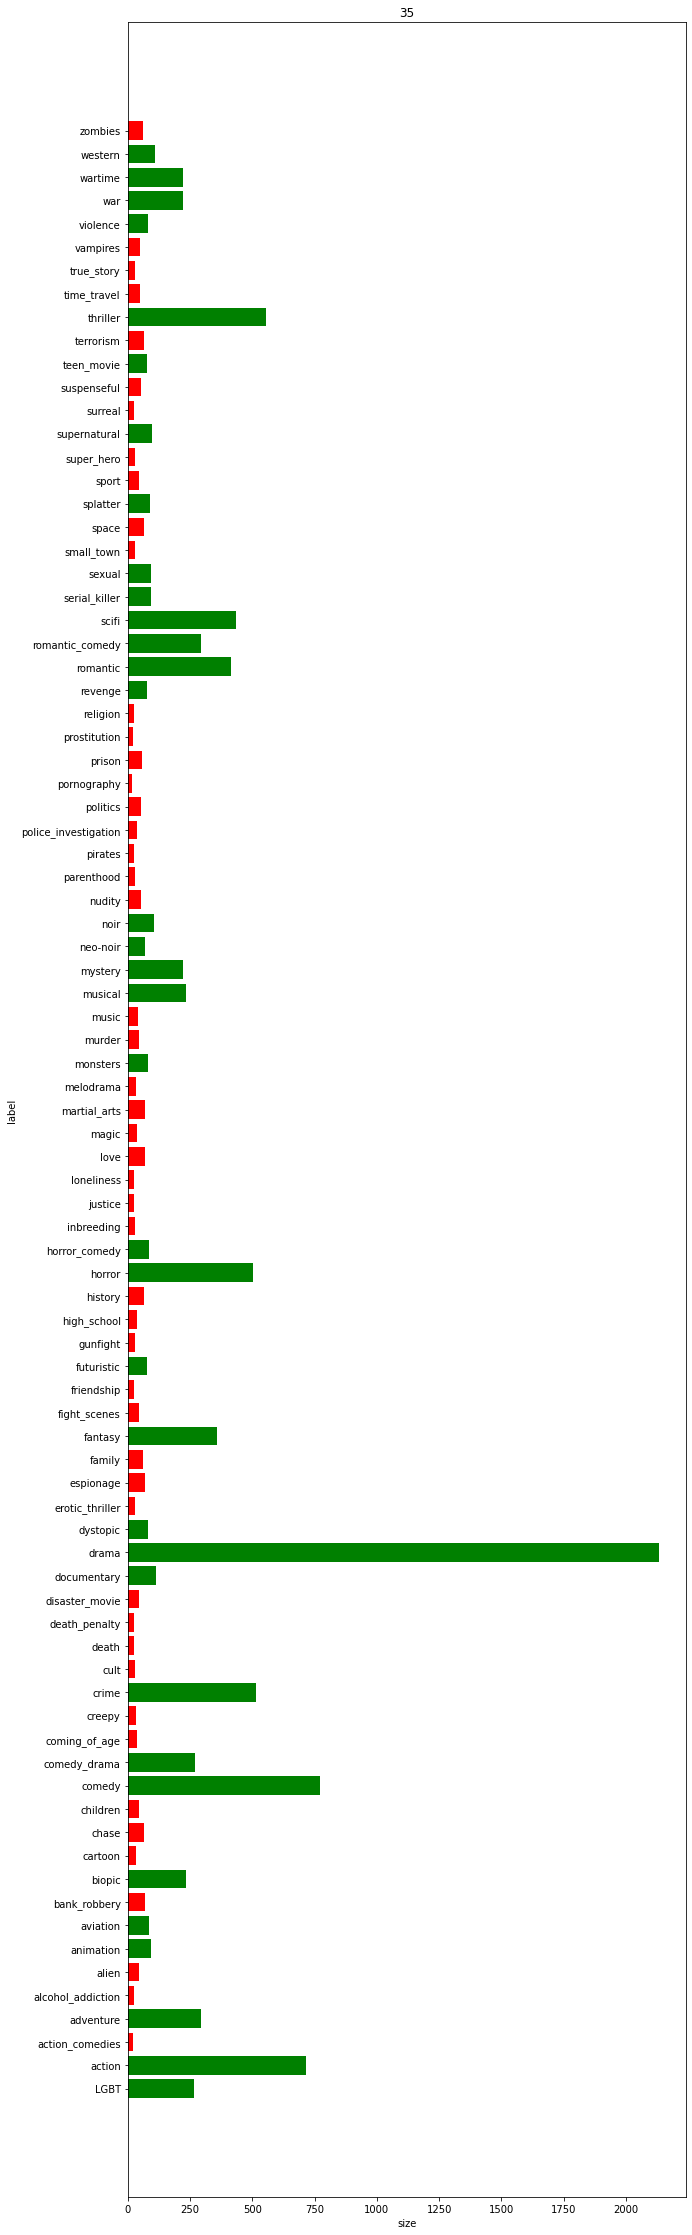

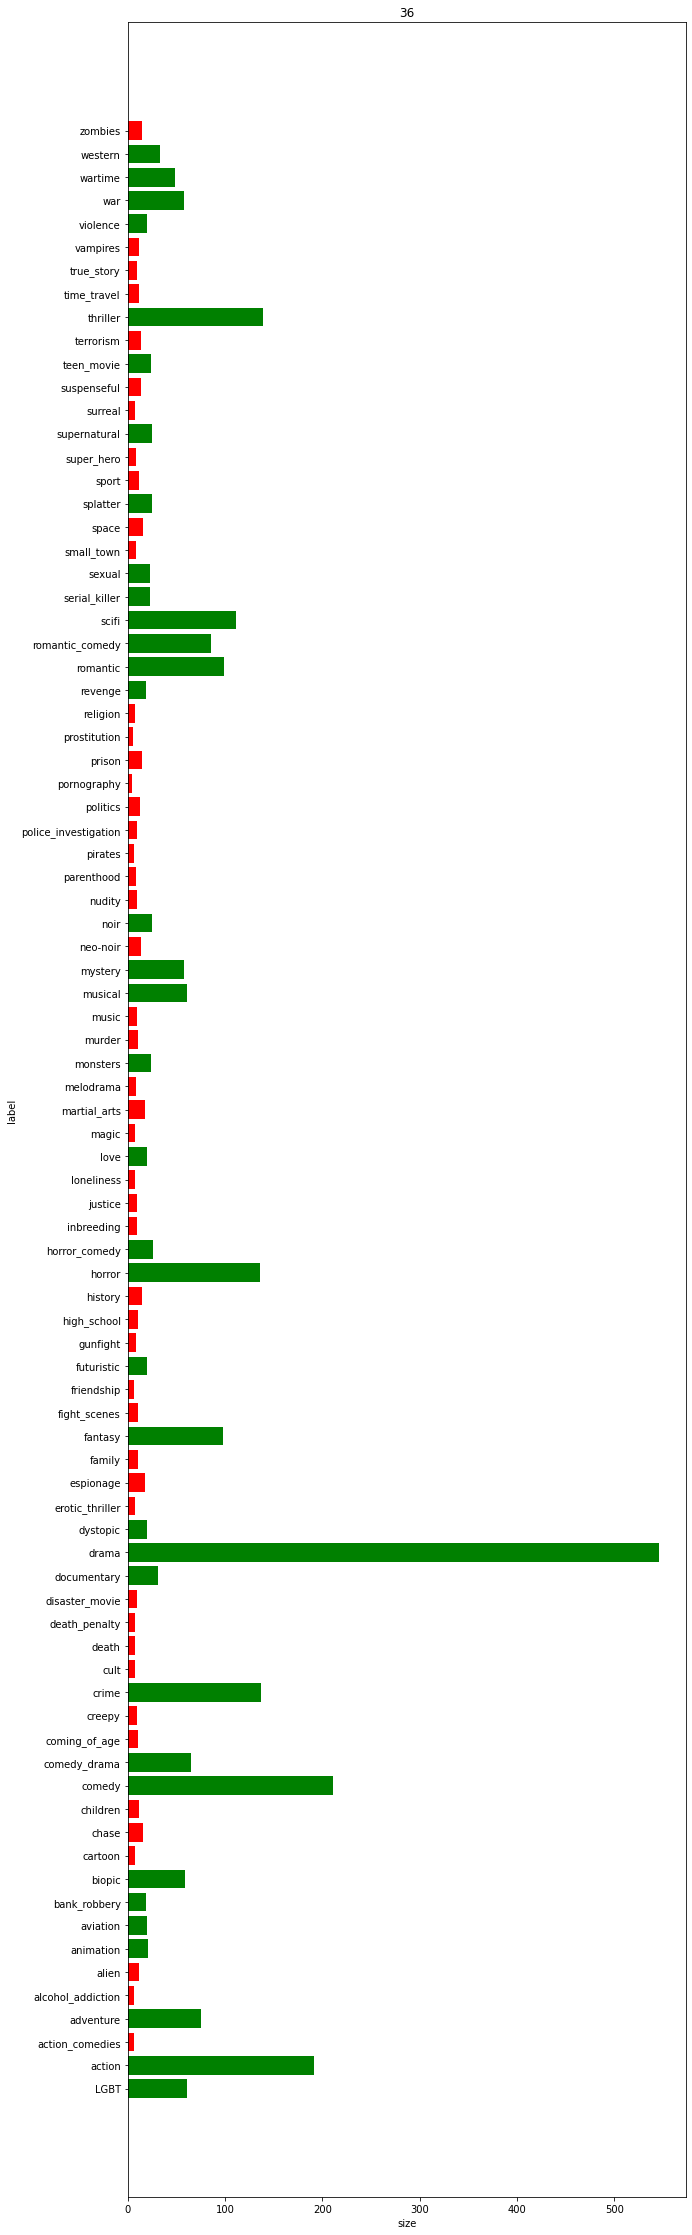

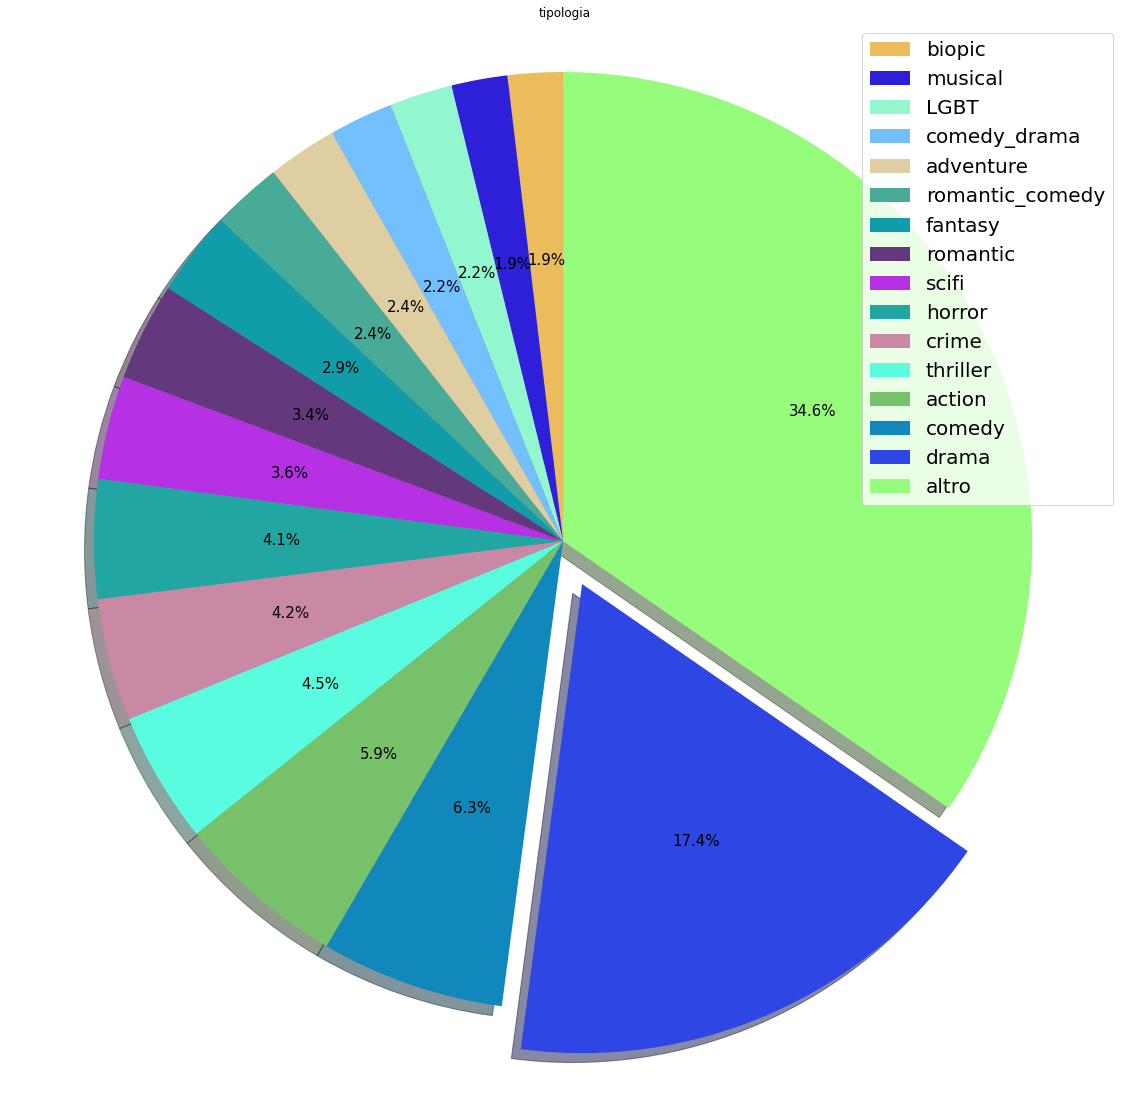

In [ ]:
label_idx.keys()
def conta_label(ds):
    class_names = label_idx.keys();
    i=0;
    occ=torch.zeros(85);
    for i in range (len(ds)):
        _,label=ds.__getitem__(i)
        occ=occ+label
    return occ

def plotta_label(o):
    # creating the dataset
    plt.figure(figsize=(10,40))
    class_names =label_idx.keys();
    plt.barh(list(class_names),o,color=colors)
    plt.title(conta_green)
    plt.ylabel("label")
    plt.xlabel("size")
    plt.show()

from random import randint
def plotta_label_pie(o):
    t=len(stampa)
    cs = []
    n = t
    for i in range(n):
        cs.append('#%06X' % randint(0, 0xFFFFFF))
    labels = stampa.keys()
    sizes = stampa.values()
    explode = np.zeros(t) 
    explode[t-2]=0.1
    fig1, ax1 = plt.subplots(figsize=(20,20))
    ax1.pie(sizes, explode=explode,  autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 15},colors=cs)
    ax1.axis('equal')  
    ax1.legend(labels, prop={'size': 20})
    plt.title('tipologia')
    plt.show()

#carica file con occ già calcolate
if os.path.isfile(file_conta_label):
    with open(file_conta_label, 'rb') as f:
        lista = np.load(f, allow_pickle=True)
        occ=lista[0]
        occ_test=lista[1]
else:
    occ=conta_label(datasetTrain)
    occ_test=conta_label(datasetTest)
    occ_list=[occ,occ_test]
    with open(file_conta_label, 'wb') as f:
        np.save(file_conta_label, np.array(occ_list))

#plotta label trainset
colors = []
ths=71;
conta_green=0;
for value in occ: # keys are the names of the boys
    if value <ths:
        colors.append('r')
    else:
        colors.append('g')
        conta_green+=1;
plotta_label(occ)

# #plotta label testset
colors = []
ths=19;
conta_green=0;
for value in occ_test:
    if value <ths:
        colors.append('r')
    else:
        colors.append('g')
        conta_green+=1;
plotta_label(occ_test)

lb=list(label_idx.keys())  
diz={}
for i in range (85):
  diz[lb[i]]=occ[i]
sorted_dict = {}
sorted_dict = sorted(diz.items(), key = lambda kv: kv[1])

stampa={}
num_stampe=15
for i in range (85-num_stampe,85):
  stampa[sorted_dict[i][0]]=int(sorted_dict[i][1])

stampa['altro']=0
for i in range (85-num_stampe):
  stampa['altro']+=int(sorted_dict[i][1])

plotta_label_pie(stampa)

# Autoencoder

In [ ]:
import torch.optim as optim
from torchvision.utils import save_image

class Autoencoder(torch.nn.Module):
               
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)
        self.relu=nn.ReLU()
        self.maxPool1=nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)
        self.conv2=nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.maxPool2=nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)
        self.conv3=nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.maxPool3=nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)
        
        self.flatten=nn.Flatten()
        
        self.unPool1=nn.MaxUnpool2d(kernel_size=3,stride=2)
        self.convT1=nn.ConvTranspose2d(in_channels=32,out_channels=64,kernel_size=3)
        self.unPool2=nn.MaxUnpool2d(kernel_size=3,stride=2)
        self.convT2=nn.ConvTranspose2d(in_channels=64,out_channels=128,kernel_size=3)
        self.unPool3=nn.MaxUnpool2d(kernel_size=3,stride=2)
        self.convT3=nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=3)
        self.sigmoid=nn.Sigmoid()
        
        
    def forward(self,x):
        
        encoder=self.conv1(x)
        encoder=self.relu(encoder)
        sizePool1=encoder.size()
        encoder,indices1=self.maxPool1(encoder)
        encoder=self.conv2(encoder)
        encoder=self.relu(encoder)
        sizePool2=encoder.size()
        encoder,indices2=self.maxPool2(encoder)
        encoder=self.conv3(encoder)
        encoder=self.relu(encoder)
        sizePool3=encoder.size()
        encoder,indices3=self.maxPool3(encoder)
        
        flatten=self.flatten(encoder)

        decoder=self.unPool1(encoder,indices3,output_size=sizePool3)
        decoder=self.relu(decoder)
        decoder=self.convT1(decoder)
        decoder=self.unPool2(decoder,indices2,output_size=sizePool2)
        decoder=self.relu(decoder)
        decoder=self.convT2(decoder)
        decoder=self.unPool3(decoder,indices1,output_size=sizePool1)
        decoder=self.relu(decoder)
        decoder=self.convT3(decoder)
        decoder=self.sigmoid(decoder)
        
        return encoder,flatten,decoder


def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, img_size, img_size)
    save_image(img, dir_autoencoder_decoded+'decoded/decoded_'+str(epoch)+'.png')

NUM_EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 16
net = Autoencoder()
net=net.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
epoca = 0
epoca, error = load_checkpoint(net,optimizer,CHECKPOINT_AUTOENCODER)
print("last epoch",epoca,"last error",error)
load_lodel(net,MODELFILE_AUTOENCODER)
last_epoch=epoca

toTensor=torchvision.transforms.ToTensor()
def train(net, trainloader, NUM_EPOCHS):
    epoca, error = load_checkpoint(net,optimizer,CHECKPOINT_AUTOENCODER)
    print("last epoch",epoca,"last error",error)
    load_lodel(net,MODELFILE_AUTOENCODER)
    train_loss = []
    try:
        for epoch in range(epoca or 0, NUM_EPOCHS-1):
            running_loss = 0.0
            steps=0;
            cont=0
            encoder=0
            flatten=0
            decoder=0
            for data in trainloader:#268 tuple [16dir,label]
                img_mean_loss=0
                mean_error_batch=0
                
                for dir in data[0]: #16 dir come batch
                   
                    mean_error_dir=0
                    for img in dir:#20 img nella directory
                    
                        img=img.view(1,3,224,224)
                        img=img.to(device)
                        optimizer.zero_grad()
                        encoder,flatten,decoder=net.forward(img)
                        
                        loss = criterion(decoder, img)
                        loss.backward()
                        optimizer.step()
                        mean_error_dir+= loss.item()
                        img_mean_loss+=loss.item()
                    
                    mean_error_dir=mean_error_dir/(len(dir))
                    mean_error_batch+=mean_error_dir
               
                cont+=1
                mean_error_batch=mean_error_batch/(len(data[0]))
                running_loss+=mean_error_batch
                print('Batch {}, Train Loss: {:.3f}'.format(cont,mean_error_batch))
            loss = float((running_loss/len(trainloader)))
            train_loss.append(loss)
            save_checkpoint(epoch+1, net, optimizer, loss,CHECKPOINT_AUTOENCODER)
            save_model(net,MODELFILE_AUTOENCODER)
            print('End, Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, loss))
    except KeyboardInterrupt:
        print('Exiting from training early')
    return encoder,flatten,decoder

last epoch None last error None


## train autoencoder

In [ ]:
# encoder,decoder,flatten,img = train(net, trainingDataLoader, NUM_EPOCHS)
print("stopped")

stopped


# vgg16

In [ ]:
#vgg
vgg=models.vgg16(pretrained = True)
for params in vgg.parameters():
    params.requires_grad = False

class NET(nn.Module):
    def __init__(self,vgg):
      super().__init__()
      
      self.features = vgg

      self.classifier = nn.Sequential(
            nn.Conv1d(iperparams["frame"],32,kernel_size=(3),padding=1,stride=2),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64,kernel_size=(3),padding=1,stride=2),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Conv1d(64, 32,kernel_size=(5),padding=1,stride=2),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(480, 85),
            nn.Sigmoid()
    )

    def forward(self, x):
        batch = torch.zeros((iperparams["batch_size"],iperparams["frame"],1000))
        index = 0
        for dir in x:
            output = self.features(dir)
            batch[index] = output
            index +=1
        ris = self.classifier(batch.to(device))
        return ris

CHECKPOINT = os.path.join(DRIVE_FOLDER, 'vgg16_epoca26.checkpoint')
MODELFILE = os.path.join(DRIVE_FOLDER, 'vgg16_epoca26.pth')

model = NET(vgg)
model = model.to(device)
load_lodel(model,MODELFILE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


# tuning vgg


In [ ]:
#Loss
pesa=False
if pesa:
    if os.path.isfile(file_conta_label):
        with open(file_conta_label, 'rb') as f:
            lista = np.load(f, allow_pickle=True)
            occ=lista[0]
            occ_test=lista[1]
    pos_weight=torch.ones([85]).to(device)
    for i in range(85):
      pos_weight[i]=occ[i]/torch.max(occ)
    print("BCELoss pesata")
    criterion = nn.BCELoss(weight=pos_weight)
else:
    print("BCELoss non pesata")
    criterion = nn.BCELoss()
    
#optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=iperparams["learning_rate"])
epoca = 0
epoca, error = load_checkpoint(model,optimizer,CHECKPOINT)
last_epoch=epoca
criterion
print(last_epoch)


BCELoss non pesata
26


### bound classi 35

In [ ]:
def verifica_y(y,occ_35,tresh):
    mask=occ_35>0
    conta=0
    for batch in range(iperparams["batch_size"]):
      for i,occ in enumerate (y[batch]):
        if occ>0 and mask[i]:
          conta+=1
    return conta>tresh  

if os.path.isfile(file_conta_label):
    with open(file_conta_label, 'rb') as f:
        lista = np.load(f, allow_pickle=True)
        occ_35=lista[0]
for i,x in enumerate(occ_35):
    if x<71:
      occ_35[i]=0
    else:
      occ_35[i]=1
ris=list(filter(lambda x: (x > 0), occ_35))

# fase di training

In [ ]:
def calcola_report(dict_=False):
    topk=10
    predictions = []
    y_true = [] 

    model.eval()

    with torch.no_grad():
        # step = 0
        for inputs, labels in testDataLoader:
            if len(inputs)<16:
              inputs_test=torch.zeros((16,20,3,224,224))
              labels_test=torch.zeros((16,85))
              inputs_test[:len(inputs)]=inputs
              labels_test[:len(labels)]=labels
              inputs=inputs_test
              labels=labels_test
            # step += 1
            # if step % print_every == 0:
            #         print(f"step {step} ")
            inputs = inputs.to(device)

            logps = model(inputs)
            y_pred = torch.sigmoid(logps)

            _, idx = y_pred.topk(topk, dim=1)

            y_pred = torch.zeros_like(y_pred)
            y_pred.scatter_(1, idx, 1)
            predictions.append(y_pred.cpu())

            y_true.append(labels.cpu())

    if dict_:
        y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
        report = classification_report(y_true, predictions,
                                      target_names=list(sorted(label_idx.keys())),output_dict=True)
        return report
    else:
        y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
        report = classification_report(y_true, predictions,
                                      target_names=list(sorted(label_idx.keys())))
        print(report)

In [ ]:
# train the network
iperparams["epoche"]=26
if last_epoch==None: last_epoch=0
#print("sono arriato alla ",last_epoch," epoca, ora inizia la ",last_epoch+1," epoca.")
epochs = iperparams["epoche"]
train_losses = []
print_every = 40

verifica_report_dopo_num_epoche=1
cifre_dopo_virgola_f1=3
try:
    for epoch in range(last_epoch or 0, epochs):
        print('Start epoch', epoch+1)
        model.train()
        running_loss = 0
        steps = 0
        for x, y in trainingDataLoader:

            steps += 1
          # if verifica_y(y,occ_35,32): 

            if epoch == 0 and steps == 1:
                print(f'input shape is {x.shape}, labels are {y.shape}')

            optimizer.zero_grad()
            logit = model(x.to(device))
            loss = criterion(logit.to(device), y.to(device))
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            # TRAIN unlabeled batch
            # ...

            if steps % print_every == 0:
                print(f"epoch {epoch+1}/{epochs}, "
                      f"train loss: {running_loss/steps:.6f}, "
                      f"Step: {steps}/{len(trainingDataLoader)} ")
                save_checkpoint(epoch+1, model, optimizer, loss,CHECKPOINT)

        save_checkpoint(epoch+1, model, optimizer, loss,CHECKPOINT)
        save_model(model,MODELFILE)
        train_losses.append(running_loss/steps)

        if ((epoch+1)%verifica_report_dopo_num_epoche)==0:
            report=calcola_report(True)
            classi_classificate=0
            for i,name in enumerate(report):
              if report[name]['f1-score']>0:
                  classi_classificate+=1
            classi_classificate=classi_classificate-4
            print(f"END Epoch {epoch+1}/{epochs}, "
                  f"Train loss: {running_loss/steps:.6f}, "
                  f"f1-score mircro avg---> {round(report['micro avg']['f1-score'],cifre_dopo_virgola_f1)}, "
                  f"n°classi con f1-score>0 ---> {classi_classificate}")
            
            score=round(report['micro avg']['f1-score'],cifre_dopo_virgola_f1)
            if score>=0.27 and classi_classificate>=36:
              epoch=epochs

        else:
            print(f"END Epoch {epoch+1}/{epochs}, "
                    f"Train loss: {running_loss/steps:.6f} ")

except KeyboardInterrupt:
    print('Exiting from training early')

# Test

In [ ]:
calcola_report()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


                      precision    recall  f1-score   support

                LGBT       0.09      0.38      0.15        61
              action       0.19      0.97      0.31       191
     action_comedies       0.00      0.00      0.00         6
           adventure       0.14      0.61      0.22        75
   alcohol_addiction       0.00      0.00      0.00         6
               alien       0.00      0.00      0.00        12
           animation       0.31      0.57      0.40        21
            aviation       0.25      0.05      0.08        20
        bank_robbery       0.33      0.05      0.09        19
              biopic       0.07      0.51      0.12        59
             cartoon       0.15      0.38      0.21         8
               chase       0.00      0.00      0.00        16
            children       0.11      0.08      0.10        12
              comedy       0.20      0.94      0.34       211
        comedy_drama       0.09      0.54      0.16        65
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
